In [4]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from mlxtend.plotting import plot_decision_regions

plt.style.use('ggplot')
%config InlineBackend.figure_format = 'svg'
%matplotlib inline
np.set_printoptions(suppress=True) # Suppress scientific notation where possible

In [5]:
from sklearn import naive_bayes
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import precision_score, recall_score, precision_recall_curve,f1_score, fbeta_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, roc_auc_score, make_scorer
from sklearn.datasets import fetch_20newsgroups
import gensim

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Import cleaned datasets

In [8]:
df_train = pd.read_csv('/content/drive/MyDrive/NLP_JCOMP/df_train.csv')
df_test = pd.read_csv('/content/drive/MyDrive/NLP_JCOMP/df_test.csv')

In [20]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 148387 entries, 0 to 148386
Data columns (total 4 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   drugName     148387 non-null  object 
 1   condition    148387 non-null  object 
 2   rating       148387 non-null  float64
 3   usefulCount  148387 non-null  float64
dtypes: float64(2), object(2)
memory usage: 5.7+ MB


In [21]:
df_train.dropna(inplace=True)

In [22]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49173 entries, 0 to 49174
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   drugName     49173 non-null  object 
 1   condition    49173 non-null  object 
 2   rating       49173 non-null  float64
 3   usefulCount  49173 non-null  int64  
 4   review       49173 non-null  object 
dtypes: float64(1), int64(1), object(3)
memory usage: 2.3+ MB


In [43]:
df_test

,drugName,condition,rating,usefulCount,review
0,Mirtazapine,Depression,10.0,22,tried antidepressant year citalopram fluoxetin...
1,Mesalamine,"Crohn's Disease, Maintenance",8.0,17,son crohn disease done well asacol no complain...
2,Bactrim,Urinary Tract Infection,9.0,3,quick reduction symptom
3,Contrave,Weight Loss,9.0,35,contrave combine drug used alcohol smoking opi...
4,Cyclafem 1 / 35,Birth Control,9.0,4,birth control one cycle reading review type si...
...,...,...,...,...,...
49170,Apri,Birth Control,9.0,18,started taking apri month ago breats got notic...
49171,Escitalopram,Anxiety,9.0,11,taking lexapro escitaploprgram since first lik...
49172,Levonorgestrel,Birth Control,8.0,7,married year old no kid taking pill hassle dec...
49173,Tapentadol,Pain,1.0,20,prescribed nucynta severe neck shoulder pain t...


In [23]:
df_test.dropna(inplace=True)

In [24]:
from wordcloud import WordCloud

def plot_wordcloud(text, mask=None, max_words=200, max_font_size=100, figure_size=(10,8), 
                   title = None, title_size=40, image_color=False):

    wordcloud = WordCloud(background_color='white',
                    max_words = max_words,
                    max_font_size = max_font_size, 
                    random_state = 42,
                    width=800, 
                    height=400,
                    mask = mask)
    wordcloud.generate(str(text))
        
    plt.figure(figsize=figure_size)
    if image_color:
        image_colors = ImageColorGenerator(mask);
        plt.imshow(wordcloud.recolor(color_func=image_colors), interpolation="bilinear");
        plt.title(title, fontdict={'size': title_size,  
                                  'verticalalignment': 'bottom'})
    else:
        plt.imshow(wordcloud);
        plt.title(title, fontdict={'size': title_size, 'color': 'black', 
                                  'verticalalignment': 'bottom'})
    plt.axis('off');
    plt.tight_layout()  

In [25]:
top_words=df_test.review.value_counts(normalize=True)[:40].keys()

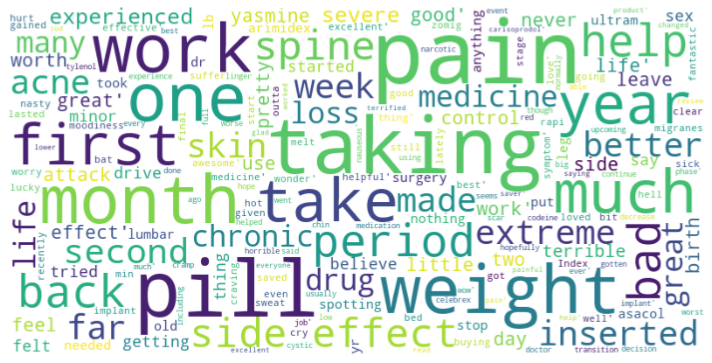

In [26]:
plot_wordcloud(top_words)
plt.savefig('wordcloud.svg')

In [27]:
df_train.rating.value_counts(normalize=True)

10.0    0.310607
9.0     0.170992
1.0     0.134742
8.0     0.117456
7.0     0.058981
5.0     0.050402
2.0     0.043905
3.0     0.041318
6.0     0.039801
4.0     0.031795
Name: rating, dtype: float64

In [28]:
# Remove 4-7 star reviews
df_train2 = df_train.drop(df_train[(df_train['rating'] > 4.0) & (df_train['rating'] < 6.0)].index)

# Set 8-10 star reviews to positive(1), the rest to negative(0)
df_train2['sentiment'] = np.where(df_train2['rating'] >= 7, '1', '0')

df_train2

,drugName,condition,rating,usefulCount,sentiment
0,Guanfacine,ADHD,8.0,192.0,1
2,Ortho Evra,Birth Control,8.0,10.0,1
3,Cialis,Benign Prostatic Hyperplasia,2.0,43.0,0
4,Levonorgestrel,Emergency Contraception,1.0,5.0,0
5,Aripiprazole,Bipolar Disorde,10.0,32.0,1
...,...,...,...,...,...
148382,Junel 1.5 / 30,Birth Control,6.0,0.0,0
148383,Metoclopramide,Nausea/Vomiting,1.0,34.0,0
148384,Orencia,Rheumatoid Arthritis,2.0,35.0,0
148385,Thyroid desiccated,Underactive Thyroid,10.0,79.0,1


In [29]:
# Remove 4-7 star reviews
df_test2 = df_test.drop(df_test[(df_test['rating'] > 4.0) & (df_test['rating'] < 6.0)].index)

# Set 8-10 star reviews to positive(1), the rest to negative(0)
df_test2['sentiment'] = np.where(df_test2['rating'] >= 7, '1', '0')

In [30]:
# Note that the dataset has mostly positive reviews
df_train2.sentiment.value_counts(normalize=True)

1    0.692963
0    0.307037
Name: sentiment, dtype: float64

In [37]:
export_csv = df_train2.to_csv(r'df_train_sentiment.csv', index = None, header=True)
export_csv = df_test2.to_csv(r'df_test_sentiment.csv', index = None, header=True)

In [38]:
X_train=df_train2.review
y_train=df_train2.sentiment
X_test=df_test2.review
y_test=df_test2.sentiment

In [40]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [41]:
from nltk.corpus import stopwords

stop = set(stopwords.words('english'))
n = ["aren't","couldn't","didn't","doesn't","don't","hadn't","hasn't","haven't","isn't",
     "mightn't","mustn't","needn't","no","nor","not","shan't","shouldn't","wasn't","weren't","wouldn't"]
for i in n:
    stop.remove(i)

a = ['mg', 'week', 'month', 'day', 'january', 'february', 'march', 'april', 'may', 'june', 'july', 
     'august', 'september','october','november','december', 'iv','oral','pound',]
for j in a:
    stop.add(j)

In [42]:
from sklearn.feature_extraction.text import CountVectorizer

cv1 = CountVectorizer(stop_words=stop, ngram_range=(1, 1), min_df=10, max_df=0.7)

X_train_cv1 = cv1.fit_transform(X_train)
X_test_cv1  = cv1.transform(X_test)

pd.DataFrame(X_train_cv1.toarray(), columns=cv1.get_feature_names()).head()

NameError: ignored

In [44]:
# The second document-term matrix has both unigrams and bigrams, and indicators instead of counts
cv2 = CountVectorizer(stop_words=stop, ngram_range=(1, 2), min_df=10, max_df=0.7)

X_train_cv2 = cv2.fit_transform(X_train)
X_test_cv2  = cv2.transform(X_test)

pd.DataFrame(X_train_cv2.toarray(), columns=cv2.get_feature_names()).head()

NameError: ignored

### Logistic Regression

In [35]:
lr = LogisticRegression()
lr.fit(X_train_cv1, y_train)
y_pred_cv1 = lr.predict(X_test_cv1)

NameError: ignored

In [ ]:
# Train the second model
lr.fit(X_train_cv2, y_train)
y_pred_cv2 = lr.predict(X_test_cv2)

In [ ]:
def conf_matrix(actual, predicted):
    cm = confusion_matrix(actual, predicted)
    sns.heatmap(cm, xticklabels=['predicted_negative', 'predicted_positive'], 
                yticklabels=['actual_negative', 'actual_positive'], annot=True,
                fmt='d', annot_kws={'fontsize':20}, cmap="YlGnBu");

    true_neg, false_pos = cm[0]
    false_neg, true_pos = cm[1]

    accuracy = round((true_pos + true_neg) / (true_pos + true_neg + false_pos + false_neg),3)
    precision = round((true_pos) / (true_pos + false_pos),3)
    recall = round((true_pos) / (true_pos + false_neg),3)
    f1 = round(2 * (precision * recall) / (precision + recall),3)

    cm_results = [accuracy, precision, recall, f1]
    return cm_results

In [ ]:
cm1=conf_matrix(y_test, y_pred_cv1)
plt.savefig('cm1_lr1.svg')

In [ ]:
cm2=conf_matrix(y_test, y_pred_cv2)
plt.savefig('cm2_lr2.svg')

In [ ]:
# Compile all of the error metrics into a dataframe for comparison
results = pd.DataFrame(list(zip(cm1, cm2)))
results = results.set_index([['Accuracy', 'Precision', 'Recall', 'F1 Score']])
results.columns = ['LogReg1', 'LogReg2']
results

### Naive Bayes

In [ ]:
# Fit the first Naive Bayes model
from sklearn.naive_bayes import MultinomialNB

mnb = MultinomialNB()
mnb.fit(X_train_cv1, y_train)

y_pred_cv1_nb = mnb.predict(X_test_cv1)

In [ ]:
# Fit the second Naive Bayes model
from sklearn.naive_bayes import BernoulliNB

bnb = BernoulliNB()
bnb.fit(X_train_cv2, y_train)

y_pred_cv2_nb = bnb.predict(X_test_cv2)

In [ ]:
# Here's the heat map for the first Naive Bayes model
cm3 = conf_matrix(y_test, y_pred_cv1_nb)
plt.savefig('cm3_nb1.svg')

In [ ]:
# Here's the heat map for the second Naive Bayes model
cm4 = conf_matrix(y_test, y_pred_cv2_nb)
# plt.savefig('/Users/jsong/Documents/durg-recommendation/fig/cm4_nb2.svg')

In [ ]:
# Compile all of the error metrics into a dataframe for comparison
results_nb = pd.DataFrame(list(zip(cm3, cm4)))
results_nb = results_nb.set_index([['Accuracy', 'Precision', 'Recall', 'F1 Score']])
results_nb.columns = ['NB1', 'NB2']
results_nb

results = pd.concat([results, results_nb], axis=1)
results

### Try using TF-IDF instead of Count Vectorizer

In [ ]:
# Create TF-IDF versions of the Count Vectorizers created earlier in the exercise
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf1 = TfidfVectorizer(stop_words=stop, ngram_range=(1, 1), min_df=10, max_df=0.7)
X_train_tfidf1 = tfidf1.fit_transform(X_train)
X_test_tfidf1  = tfidf1.transform(X_test)

In [ ]:
tfidf2 = TfidfVectorizer(stop_words=stop, ngram_range=(1, 2), min_df=10, max_df=0.7)
X_train_tfidf2 = tfidf2.fit_transform(X_train)
X_test_tfidf2  = tfidf2.transform(X_test)

In [ ]:
# Fit the first logistic regression on the TF-IDF data
lr.fit(X_train_tfidf1, y_train)
y_pred_tfidf1_lr = lr.predict(X_test_tfidf1)
cm5 = conf_matrix(y_test, y_pred_tfidf1_lr)
plt.savefig('cm5_tf_idf_lr1.svg')

In [ ]:
# Fit the second logistic regression on the TF-IDF data
lr.fit(X_train_tfidf2, y_train)
y_pred_tfidf2_lr = lr.predict(X_test_tfidf2)
cm6 = conf_matrix(y_test, y_pred_tfidf2_lr)
plt.savefig('cm6_tf_idf_lr2.svg')

In [ ]:
# Fit the first Naive Bayes model on the TF-IDF data
mnb.fit(X_train_tfidf1.toarray(), y_train)
y_pred_tfidf1_nb = mnb.predict(X_test_tfidf1)
cm8 = conf_matrix(y_test, y_pred_tfidf1_nb)
plt.savefig('cm8_tf_idf_nb1.svg')

In [ ]:
# # Fit the second Naive Bayes model on the TF-IDF data
bnb.fit(X_train_tfidf2.toarray(), y_train)
y_pred_tfidf2_nb = bnb.predict(X_test_tfidf2)
cm9 = conf_matrix(y_test, y_pred_tfidf2_nb)
plt.savefig('cm9_tf_idf_nb2.svg')

In [ ]:
# Compile all of the error metrics into a dataframe for comparison
results_tf = pd.DataFrame(list(zip(cm5, cm6, cm8, cm9)))
results_tf = results_tf.set_index([['Accuracy', 'Precision', 'Recall', 'F1 Score']])
results_tf.columns = ['LR1-TFIDF', 'LR2-TFIDF', 'NB1-TFIDF', 'NB2-TFIDF']
results_tf

results = pd.concat([results, results_tf], axis=1)
results